Clustering practice

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def kmeans(k, points):
  prev_assignment = []

  # 1. 임의로 k개의 점을 중심적으로 선택 (forgy)
  centroids = points[np.random.choice(points.shape[0], replace=False, size=k)]
  # choice 함수 -> 0부터 points.shape[0]-1까지 랜덤하게 k개 뽑는다. replace=False -> 중복 방지

  for epoch in range(10):
    # 2. 각 점이 할당될 중심점을 계산 (각 point가 어떤 centroid랑 가장 가까운지 계산 (즉, 어느 클러스터에 속하는지 계산))
    # 방법 1
    assignments = [assign(p, centroids, k) for p in points]

    # 방법 2
    # assignments = []

    # for p in points:
    #   min_dist = 9e9
    #   min_cid = -1 # cid -> 몇번째 centroid인지 체크
    #   for cid, c in enumerate(centroids):
    #     dist = ((c-p) ** 2).sum()
    #     if dist < min_dist:
    #       min_dist = dist
    #       min_cid = cid
    #     assignments.append(min_cid)

    # 3. 새로운 centroids 계산 (assignment를 기준으로, 새로운 centroid를 계산하기)
    # 방법 1
    centroids = compute_centroids(assignments, points, k)

    # 방법 2
    # cf_ex) assignments = np.array([1,3,2,4,1,4])
    #        assignments == 1 -> [True,False,False,False,True,False]
    #        points[assignments == 1] = [[2,3,4], [4,5,6]]
    # centroids = np.array([points[np.array(assignments) == cid].mean(axis=0) for cid, c in enumerate(centroids)])

    # 4. 변경이 발생했는지 확인
    if prev_assignment == assignments:
      break
    prev_assignment = assignments

  return assignments, centroids

In [ ]:
def assign(point, centroids, k):
  return min(range(k), key=lambda i: np.dot(centroids[i]-point, centroids[i]-point))

def compute_centroids(assignments, points, k):
  vec_sum = [np.zeros(len(points[0])) for _ in range(k)]
  counts = [0] * k

  for i, p in zip(assignments, points):
    vec_sum[i] += p
    counts[i] += 1

  return [vec_sum[i]/counts[i] if counts[i] > 0 else random.choice(points) for i in range(k)]

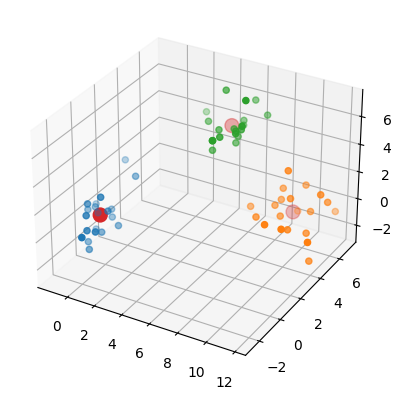

In [ ]:
k = 3

points1 = np.random.randn(20, k)
points2 = np.random.randn(20, k) + np.array([5, 5, 5])
points3 = np.random.randn(20, k) + np.array([10, 5, 0])
points = np.concatenate( (points1, points2, points3) )

assignments, centroids = kmeans(k, points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

clusters = [[] for _ in range(k)]
for a, p in zip(assignments, points):
  clusters[a].append(p)

for cluster in clusters:
  ax.scatter(*zip(*cluster))

ax.scatter(*zip(*centroids), s=100)
plt.show()

In [ ]:
!wget https://cdn.aitimes.com/news/photo/202303/150063_159019_5413.jpg

--2023-11-28 14:51:05--  https://cdn.aitimes.com/news/photo/202303/150063_159019_5413.jpg
Resolving cdn.aitimes.com (cdn.aitimes.com)... 27.102.87.111
Connecting to cdn.aitimes.com (cdn.aitimes.com)|27.102.87.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139743 (136K) [image/jpeg]
Saving to: ‘150063_159019_5413.jpg’

150063_159019_5413. 100%[===================>] 136.47K   176KB/s    in 0.8s    

2023-11-28 14:51:08 (176 KB/s) - ‘150063_159019_5413.jpg’ saved [139743/139743]



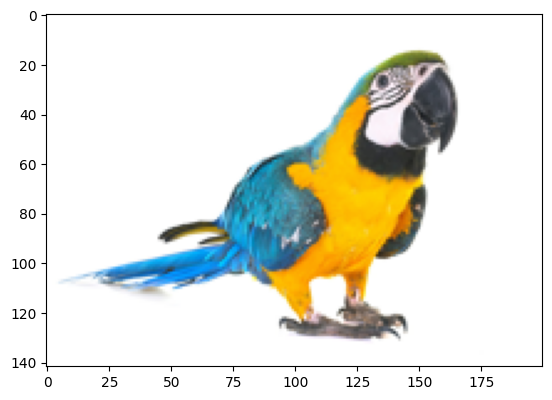

In [ ]:
from PIL import Image

im = Image.open("150063_159019_5413.jpg")

width = 200
height = im.height * width // im.width

im = im.resize( (width, height) )

plt.imshow(im)
plt.show()

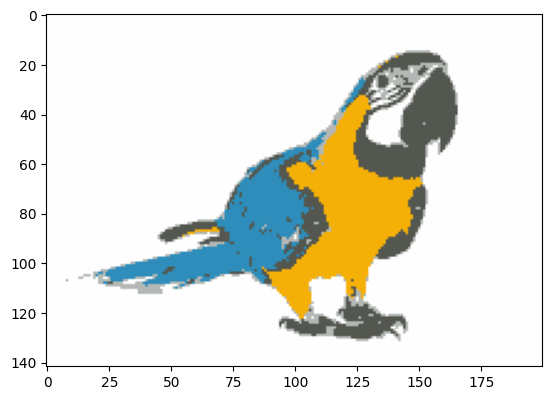

In [ ]:
pixels = np.array(im).reshape((-1,3))
assignments, centroids = kmeans(5, pixels)

for a, i in zip(assignments, range(pixels.shape[0])):
  pixels[i] = centroids[a]

im_remastered = Image.fromarray(pixels.reshape(im.height, im.width, 3), 'RGB')
plt.imshow(im_remastered)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


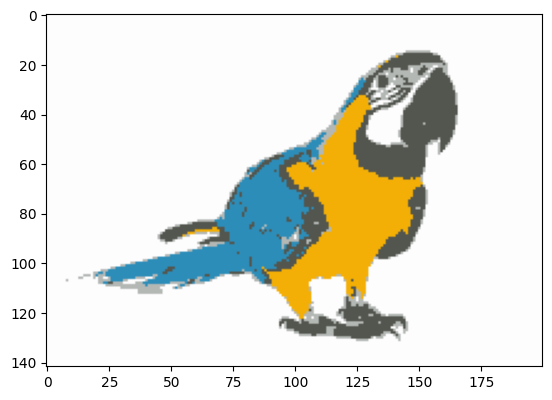

In [ ]:
from sklearn.cluster import KMeans

# pixels는 위에 데이터 그대로 사용
kmeans = KMeans(n_clusters=5)
kmeans.fit(pixels)

for a, i in zip(kmeans.labels_, range(pixels.shape[0])):
  pixels[i] = kmeans.cluster_centers_[a]

im_remastered = Image.fromarray(pixels.reshape(im.height, im.width, 3), 'RGB')
plt.imshow(im_remastered)
plt.show()

knn practice

In [ ]:
!wget https://archive.ics.uci.edu/static/public/53/iris.zip
!unzip iris.zip

--2023-11-28 14:51:26--  https://archive.ics.uci.edu/static/public/53/iris.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.zip’

iris.zip                [ <=>                ]   3.65K  --.-KB/s    in 0s      

2023-11-28 14:51:27 (615 MB/s) - ‘iris.zip’ saved [3738]

Archive:  iris.zip
  inflating: Index                   
  inflating: bezdekIris.data         
  inflating: iris.data               
  inflating: iris.names              


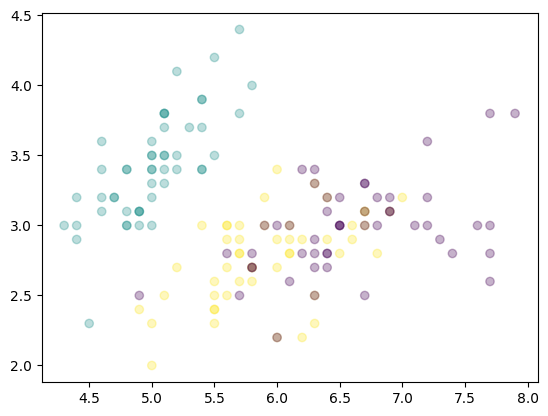

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = []
y = []
for line in open("iris.data", "r"):
  line = line.strip() # 개행문자나 공백 지우기
  if line != "":
    tokens = line.split(",")
    x.append([float(t) for t in tokens[:4]]) # 리스트 안에 값들 타입을 변경하는 방법
    y.append(tokens[4])

y_labels = list(set(y))
y = [y_labels.index(a) for a in y] # 문자열을 인덱스 값을 이용해서 숫자화

x = np.array(x)
y = np.array(y)

plt.scatter(x[:,0], x[:,1], c=y, alpha=0.3)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 41) # shuffle = true가 기본값, random값 고정, 순서 참고!
# test data와 train data를 비율로 나누기
# -> 20퍼센트를 test 데이터로 쓰겠다.

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train) # 아무일도 일어나지 않음 but 데이터가 클때와 같은 특정 경우에 사용됨

y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)

print("train accuracy:", accuracy_score(y_train_pred, y_train)) # print(sum(y_train_pred == y_train) / len(x_train))
print("test accuracy:", accuracy_score(y_test_pred, y_test))

train accuracy: 0.9833333333333333
test accuracy: 0.9666666666666667


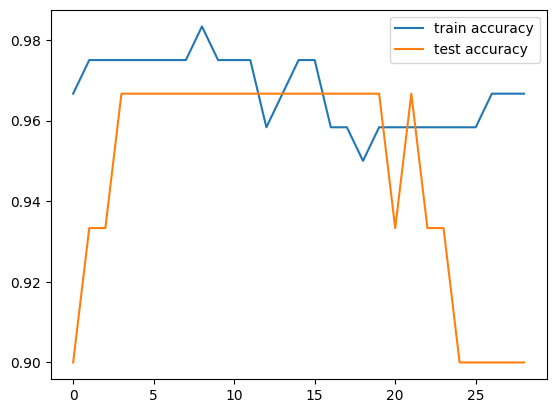

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

scores = []
test_scores = []

for k in range(1,30):
  knn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(knn, x_train, y_train, cv=10, scoring="accuracy")
  scores.append(score.mean())

  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  test_scores.append(accuracy_score(y_test, y_pred))

plt.plot(scores, label="train accuracy")
plt.plot(test_scores, label="test accuracy")
plt.legend()

plt.show()